In [490]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [491]:
rawData = pd.read_excel('Sample Dataset.xlsx', index_col=0)

In [492]:
# get some sense what the data look like
rawData.head()

,Signal,Open,High,Low,Close,Adj Close
Date,,,,,,
2015-11-19,13.768540,116.440002,116.650002,115.739998,116.059998,108.281601
2015-11-20,13.608819,116.480003,117.360001,116.379997,116.809998,108.981323
2015-11-23,12.990589,116.709999,117.889999,116.680000,117.389999,109.522453
2015-11-24,12.667435,116.879997,118.419998,116.559998,118.250000,110.324837
2015-11-25,13.019910,118.300003,119.320000,118.110001,119.169998,111.183159


In [493]:
# from this summary, it seems no missing data. 
# but from the percentiles/min/max, we seem some potential error: 1) 0 value in the Singal; 2) negative value in the ETF Adj Close price. 
rawData.describe()

,Signal,Open,High,Low,Close,Adj Close
count,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000
mean,16.766190,141.847360,142.691801,140.907746,141.840973,136.341060
std,3.095783,18.475574,18.470255,18.404504,18.497010,21.427837
min,0.000000,94.080002,95.400002,93.639999,94.790001,-152.277847
25%,14.691150,132.132496,132.912495,130.542503,131.824993,125.290491
50%,17.298240,146.769997,147.959999,145.634995,146.885002,142.667732
75%,19.030890,155.367496,156.287495,154.422500,155.289993,151.798325
max,35.434147,172.789993,173.389999,171.949997,196.279999,168.842270


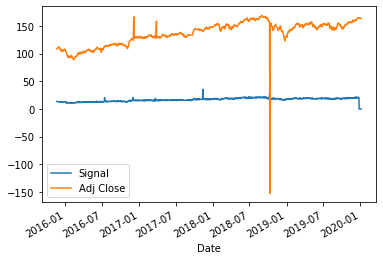

In [494]:
# it is more obvious to see those outliers in the plots.
neededCols = ['Signal', 'Adj Close']
orignalColumns = rawData.columns
rawData.loc[:, neededCols].plot()

In [495]:
def zscore(ts, avg=None, std=None):
    if avg:
        return (ts-avg)/std
    else:
        return (ts-np.mean(ts))/np.std(ts)

def dataFilter(df, columns, threshold=5):
    stats = df.describe()
    condition = None
    for col in columns:
        oneFilter = abs(zscore(df.loc[:, col]))>=threshold
        if condition is None:
            condition = oneFilter
        else:
            condition |= oneFilter
    return condition

In [496]:
# a z-score of 5 or larger is associated with very rare event. so we can almost be sure that it is caused by error with current ~1000 
# data points. 
filterCondition1 = dataFilter(rawData, neededCols, 5)
rawData['Outlier'] = 0
rawData.loc[filterCondition1, 'Outlier'] = 1
print(rawData.loc[rawData['Outlier']==1,:])
# As we can see those outliers are all with zscore larger than 5. For 'Signal' column, there are a series of 0s, that should be errors.
# The signal has 6 zeros in the end. I do not have good ways to correct. So removal might be OK. The first outlier is too large, so I 
# can correct it by fill forward with previous day's value. 
# The one with Adj Close is interesting: the negative sign must be put by mistake. If I remove it, I end up with same return as the 
# 'close' column. So I will just put the absolute value there. 
# These 3 treatment will be performed one by one. 
outlierDates = rawData.loc[rawData['Outlier']==1,:].index
firstOutlierDate = outlierDates[0]
secondOutlierDate = outlierDates[1]
rawData.loc[firstOutlierDate, 'Outlier'] = 0 # to keep and correct
rawData.loc[secondOutlierDate, 'Outlier'] = 0 # to keep and correct
cleanedData = rawData.loc[rawData['Outlier']==0,:]
firstIndex = list(rawData.index).index(firstOutlierDate)
firstOutlierPrevDate = rawData.index[firstIndex-1]
cleanedData.loc[firstOutlierDate,'Signal'] = cleanedData.loc[firstOutlierPrevDate,'Signal']
cleanedData.loc[secondOutlierDate,'Adj Close'] = abs(cleanedData.loc[secondOutlierDate,'Adj Close'])
cleanedData.loc[outlierDates[:2],:] # verify it is corrected 

               Signal        Open        High         Low       Close  \
Date                                                                    
2017-11-13  35.434147  145.929993  146.820007  145.500000  146.610001   
2018-10-10  19.719477  160.820007  160.990005  156.360001  156.559998   
2019-12-27   0.000000  167.119995  167.119995  165.429993  165.860001   
2019-12-30   0.000000  165.979996  166.210007  164.570007  165.440002   
2019-12-31   0.000000  165.080002  166.350006  164.710007  165.669998   
2020-01-02   0.000000  166.740005  166.750000  164.229996  165.779999   
2020-01-03   0.000000  163.740005  165.410004  163.699997  165.130005   
2020-01-06   0.000000  163.850006  165.539993  163.539993  165.350006   

             Adj Close  Outlier  
Date                             
2017-11-13  140.849274        1  
2018-10-10 -152.277847        1  
2019-12-27  164.039063        1  
2019-12-30  163.623688        1  
2019-12-31  163.851135        1  
2020-01-02  163.959946        1

C:\Users\toxuc\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Signal,Open,High,Low,Close,Adj Close,Outlier
Date,,,,,,,
2017-11-13,17.628384,145.929993,146.820007,145.500000,146.610001,140.849274,0
2018-10-10,19.719477,160.820007,160.990005,156.360001,156.559998,152.277847,0


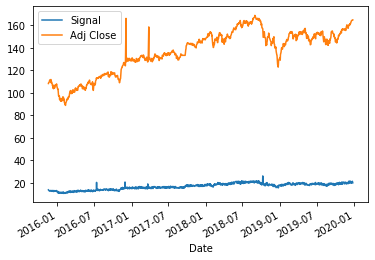

In [497]:
# after initial cleaning of the raw data, we can see from the plot below that some obviously wrong data got removed. 
# but still there are some jumps. 
cleanedData.loc[:, neededCols].plot()

In [498]:
# after initial filtering, there seems still some outliers in the data
# using return data may be able to get rid of those outliers.
rets = cleanedData.drop(['Outlier'], axis=1).pct_change()
rets.describe()
# These daily return values show that both signal and adj close have a close to 0 average return. However, the signal is much more 
# volatile than the ETF, with a std of 5% vs.ETF's 2%. Looking at the min and max values, there are more than 5 std away from the mean.
# I shall apply similar rule to remove those records with abnormally high or low returns. Those look like data errors to me.

,Signal,Open,High,Low,Close,Adj Close
count,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000
mean,0.001774,0.000401,0.000385,0.000400,0.000453,0.000579
std,0.053528,0.010179,0.008592,0.009823,0.014309,0.018880
min,-0.330036,-0.053984,-0.045611,-0.036805,-0.203994,-0.232498
25%,-0.031339,-0.004921,-0.004237,-0.004579,-0.004808,-0.004859
50%,0.000641,0.000891,0.000551,0.000763,0.000913,0.000925
75%,0.033920,0.006164,0.005452,0.006264,0.006453,0.006508
max,0.473045,0.052337,0.028256,0.038712,0.243853,0.339658


In [499]:
retFilter = dataFilter(rets, neededCols, 5)
cleanedData.loc[retFilter, 'Outlier'] = 1
cleanedData['Signal_zscore'] = zscore(cleanedData['Signal'])
cleanedData['Adj Close_zscore'] = zscore(cleanedData['Adj Close'])
print(rets.loc[retFilter])
# We can see there are abnormal returns either for signal, or for ETF prices.One interesting observation is that the abnormal returns 
# usually come in pairs: one large positive return followed by one large negative return or vice versa. It is understandable as one 
# abnormal data point in price can cause two abnormal returns: one for today and the other for the next day (assumming the data points
# around that abnormal data point are normal). 
# Another observation of those return data is that for the cases that adj close has abnormal returns, the Open, High, Low, Close returns 
# are pretty normal (especially the Close returns are almost in sync with Adj Close in normal circumstances.
# I can use this observation to proxy the Adj Close returns with the Close price returns. 
print(cleanedData.loc[retFilter])

              Signal      Open      High       Low     Close  Adj Close
Date                                                                   
2016-07-13  0.473045  0.011176 -0.000249  0.001010 -0.003926  -0.003926
2016-07-14 -0.330036 -0.000249 -0.000249  0.002942  0.001006   0.001006
2016-11-30  0.352664  0.003094  0.000000 -0.004542 -0.004915  -0.004915
2016-12-05  0.068105  0.007866  0.014148  0.010496  0.017189   0.339658
2016-12-06 -0.007867  0.011745  0.011850  0.006445  0.010815  -0.232498
2017-03-22  0.300647 -0.034654 -0.030952 -0.008513  0.000224   0.000224
2017-03-27  0.059497 -0.016228 -0.002953 -0.010907  0.001859   0.235615
2017-03-28  0.011422  0.011449  0.006145  0.013142  0.007793  -0.182863
2018-10-09  0.282660 -0.000927  0.002094  0.002678 -0.003893  -0.003893
               Signal        Open        High         Low       Close  \
Date                                                                    
2016-07-13  20.395083  120.330002  120.389999  118.949997  119

C:\Users\toxuc\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\toxuc\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\toxuc\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [500]:
# Based on the previous observation, I cannot directly remove those records that have abnormal returns. Rather, I write a loop to handle 
# the case one by one. Although a bit slow, it can avoid the problem of one jump causing two records removed (itself and the one after!)
def correctRecordsWithAbnormalReturns(cleanedData, rets, zscoreThreshold=5):
    count = 0
    correctedData = {}
    tempData = cleanedData.copy()
    signalRetMean = rets.describe().loc['mean', 'Signal']
    signalRetStd = rets.describe().loc['std', 'Signal']
    ETFRetMean = rets.describe().loc['mean', 'Adj Close']
    ETFRetStd = rets.describe().loc['std', 'Adj Close']
    for i in range(1, len(tempData)):
        current = tempData.iloc[i,:]
        previous = tempData.iloc[i-1,:]
        currentDate = (tempData.index[i])
        previousDate = (tempData.index[i-1])
        signalRet = current['Signal'].squeeze() / previous['Signal'].squeeze() - 1
        ETFRet = current['Adj Close'].squeeze() / previous['Adj Close'].squeeze() - 1
        signalZscore = zscore(signalRet, signalRetMean, signalRetStd)
        ETFZscore = zscore(ETFRet, ETFRetMean, ETFRetStd)
        if abs(signalZscore)>=zscoreThreshold:
            count +=1
            badData = tempData.loc[currentDate, 'Signal']
            tempData.loc[currentDate, 'Signal'] = tempData.loc[previousDate, 'Signal']
            correctedData[('Signal',currentDate)] = (badData, tempData.loc[currentDate, 'Signal'])
        elif abs(ETFZscore)>=zscoreThreshold:
            count +=1
            badData = tempData.loc[currentDate, 'Adj Close']
            tempData.loc[currentDate, 'Adj Close'] = tempData.loc[previousDate, 'Adj Close'] * (1+rets.loc[currentDate, 'Close'])
            correctedData[('Adj Close',currentDate)] = (badData, tempData.loc[currentDate, 'Adj Close'])
    return tempData, count, correctedData
cleanedData2, count, correctedData = correctRecordsWithAbnormalReturns(cleanedData, rets, zscoreThreshold=5)
print('{} data points corrected!'.format(count))
for key, valuePair in correctedData.items():
    print(key)
    print('{}-->{}'.format(valuePair[0], valuePair[1]))

6 data points corrected!
('Signal', Timestamp('2016-07-13 00:00:00'))
20.3950827-->13.845523248
('Signal', Timestamp('2016-11-30 00:00:00'))
20.738649859200002-->15.3317071368
('Adj Close', Timestamp('2016-12-05 00:00:00'))
166.175079-->126.175074159609
('Signal', Timestamp('2017-03-22 00:00:00'))
19.02931644-->14.630651699999998
('Adj Close', Timestamp('2017-03-27 00:00:00'))
158.577637-->128.5776161484658
('Signal', Timestamp('2018-10-09 00:00:00'))
26.12487282288-->20.367731340000002


(1032, 9)


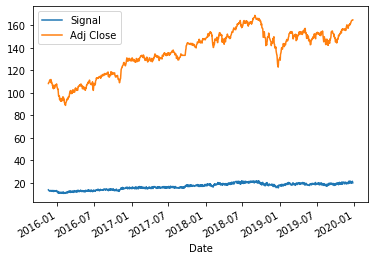

In [501]:
# as expected the extra outliers were removed from the initial cleaned data.
# now the time series data for both the 'Signal' and the 'Adj Close' look reasonable. 
cleanedData2.loc[:, neededCols].plot()
print(cleanedData2.shape)

In [502]:
# check duplicates in the data
cleanedData3 = cleanedData2.copy()
print(cleanedData3.groupby(['Adj Close'])['Adj Close'].count().sort_values(ascending=False).head(30))
# There seems to be severe duplicates in the Adj Close prices. Take a deep dive on it. 

Adj Close
133.321198    12
116.178825     3
142.616989     2
160.489944     2
149.865677     2
152.487717     2
115.328331     2
135.600998     2
129.579605     2
129.588120     2
145.334091     2
103.730415     2
129.808640     2
117.333832     2
159.562042     2
106.484169     2
157.493622     2
132.623718     2
156.352997     2
132.024063     2
131.928925     2
107.903297     2
128.313110     2
155.792709     2
165.552902     2
164.850052     2
128.265549     1
130.599396     1
127.046913     1
130.810226     1
Name: Adj Close, dtype: int64


,Signal,Open,High,Low,Close,Adj Close,Outlier,Signal_zscore,Adj Close_zscore
Date,,,,,,,,,
2017-09-07,16.478500,139.589996,139.690002,138.589996,139.110001,133.321198,0,-0.132997,-0.162633
2017-09-08,15.518587,138.929993,139.770004,138.619995,139.110001,133.321198,0,-0.479996,-0.162633
2017-09-11,15.838558,140.389999,140.919998,140.229996,139.110001,133.321198,0,-0.364330,-0.162633
2017-09-12,15.518587,141.039993,141.690002,140.820007,139.110001,133.321198,0,-0.479996,-0.162633
2017-09-13,16.158529,141.410004,142.220001,141.320007,139.110001,133.321198,0,-0.248663,-0.162633
2017-09-14,16.478500,141.779999,142.160004,141.419998,139.110001,133.321198,0,-0.132997,-0.162633
2017-09-15,15.198617,141.639999,142.470001,141.550003,139.110001,133.321198,0,-0.595662,-0.162633
2017-09-18,15.518587,142.619995,143.809998,142.600006,139.110001,133.321198,0,-0.479996,-0.162633
2017-09-19,16.798471,143.570007,143.690002,143.089996,139.110001,133.321198,0,-0.017331,-0.162633


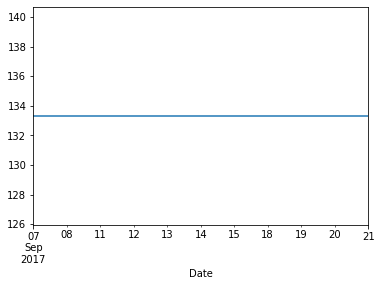

In [503]:
adjCloseCounts = cleanedData3.groupby(['Adj Close'])['Adj Close'].count().sort_values(ascending=False)
adjDuplicates = cleanedData3[cleanedData3['Adj Close'] == adjCloseCounts[adjCloseCounts>=3].index[0]]
minDupDate = min(adjDuplicates.index)
maxDupDate = max(adjDuplicates.index)
minDupIndex = list(cleanedData3.index).index(minDupDate)
maxDupIndex = list(cleanedData3.index).index(maxDupDate)
cleanedData3.iloc[minDupIndex:maxDupIndex, :]['Adj Close'].plot()
adjDuplicates
# from the plot we can see that the duplicates happens on consecutive dates, which is also true by looking at the data itself.
# Will design an algorithm to correct those duplicate in the next section. 

In [504]:
# Correct the block duplicates with returns implied from Open, high, low (basically take an average of the three)
pctEst = cleanedData3.pct_change().loc[adjDuplicates.index[1:],:][['Open', 'High', 'Low']].mean(axis=1)
start = cleanedData3.loc[adjDuplicates.index[0],['Adj Close']]
cumRet = (pctEst+1).cumprod()
cleanedData3.loc[adjDuplicates.index[1:],'Adj Close'] = (cumRet*(start.squeeze())).values
print(cleanedData3.loc[adjDuplicates.index[0:],:])
cleanedData3.shape


               Signal        Open        High         Low       Close  \
Date                                                                    
2017-09-07  16.478500  139.589996  139.690002  138.589996  139.110001   
2017-09-08  15.518587  138.929993  139.770004  138.619995  139.110001   
2017-09-11  15.838558  140.389999  140.919998  140.229996  139.110001   
2017-09-12  15.518587  141.039993  141.690002  140.820007  139.110001   
2017-09-13  16.158529  141.410004  142.220001  141.320007  139.110001   
2017-09-14  16.478500  141.779999  142.160004  141.419998  139.110001   
2017-09-15  15.198617  141.639999  142.470001  141.550003  139.110001   
2017-09-18  15.518587  142.619995  143.809998  142.600006  139.110001   
2017-09-19  16.798471  143.570007  143.690002  143.089996  139.110001   
2017-09-20  15.953688  143.529999  144.020004  143.259995  139.110001   
2017-09-21  16.004491  144.020004  144.259995  143.479996  139.110001   
2017-09-22  16.997600  143.669998  144.669998  143.

(1032, 9)

In [505]:
# handle other duplicates other than the block one with duplicate count 3
cleanedData4 = cleanedData3.copy()
adjDuplicates2 = cleanedData4[cleanedData4['Adj Close'] == adjCloseCounts[adjCloseCounts>=3].index[1]]
print(adjDuplicates2)
for i in range(1, len(adjDuplicates2)):
    currentDate = adjDuplicates2.index[i]
    previousDate = adjDuplicates2.index[i-1]
    if list(cleanedData4.index).index(currentDate) - list(cleanedData4.index).index(previousDate)==1: # meaning consecutive
        cleanedData4.loc[currentDate, 'Adj Close'] = cleanedData4.loc[currentDate, 'Adj Close']* \
        (1+cleanedData4.pct_change().loc[currentDate,:][['Open', 'High', 'Low']].mean())
print(cleanedData4.loc[adjDuplicates2.index,:])    

               Signal        Open        High         Low       Close  \
Date                                                                    
2016-08-18  14.070737  122.080002  122.970001  122.040001  122.940002   
2016-08-19  14.374889  122.769997  123.070000  122.279999  122.940002   
2016-09-12  14.116188  120.690002  122.970001  120.580002  122.940002   

             Adj Close  Outlier  Signal_zscore  Adj Close_zscore  
Date                                                              
2016-08-18  116.178825        0      -1.003380         -1.046064  
2016-08-19  116.178825        0      -0.893432         -1.046064  
2016-09-12  116.178825        0      -0.986950         -1.046064  
               Signal        Open        High         Low       Close  \
Date                                                                    
2016-08-18  14.070737  122.080002  122.970001  122.040001  122.940002   
2016-08-19  14.374889  122.769997  123.070000  122.279999  122.940002   
2016-09

In [506]:
# Now we only left with duplicates count 2 for Adj Close. Leave it for now - handle it if there is extra time. 
print(cleanedData4.groupby(['Open','High','Low','Close', 'Adj Close'])['Adj Close'].count().sort_values(ascending=False).head(10))

Open        High        Low         Close       Adj Close 
165.229996  166.660004  164.850006  166.039993  160.489944    2
167.240005  167.369995  164.139999  165.080002  159.562042    2
162.369995  163.240005  162.360001  162.940002  157.493622    2
163.259995  163.330002  161.630005  161.759995  156.352997    2
136.229996  137.300003  136.210007  136.649994  130.025879    1
136.490005  137.809998  136.229996  137.490005  131.768616    1
136.979996  137.690002  134.919998  134.929993  129.315140    1
136.889999  136.979996  134.830002  135.250000  128.693710    1
136.880005  137.309998  136.419998  136.880005  131.183990    1
136.839996  136.919998  134.639999  136.320007  130.085373    1
Name: Adj Close, dtype: int64


In [507]:
# move ahead with checking duplicates for the signal. 
print(cleanedData4.groupby(['Signal'])['Signal'].count().sort_values(ascending=False).head(20))

Signal
16.478500    3
15.518587    3
19.483907    2
15.282748    2
12.139195    2
13.845523    2
20.274163    2
15.705525    2
17.628384    2
20.367731    2
15.331707    2
14.630652    2
18.995502    2
20.448445    2
15.673822    1
15.690014    1
15.685586    1
15.694927    1
15.682386    1
15.675808    1
Name: Signal, dtype: int64


In [508]:
signalCounts = cleanedData4.groupby(['Signal'])['Signal'].count().sort_values(ascending=False)
signalDuplicates
cleanedData4[cleanedData4['Signal'] == signalCounts[signalCounts>=3].index[0]]
# the duplicates are not consecutive, may just leave them as is.

,Signal,Open,High,Low,Close,Adj Close,Outlier,Signal_zscore,Adj Close_zscore
Date,,,,,,,,,
2017-09-01,16.4785,139.979996,140.630005,139.729996,140.520004,134.672531,0,-0.132997,-0.092992
2017-09-07,16.4785,139.589996,139.690002,138.589996,139.110001,133.321198,0,-0.132997,-0.162633
2017-09-14,16.4785,141.779999,142.160004,141.419998,139.110001,135.712108,0,-0.132997,-0.162633


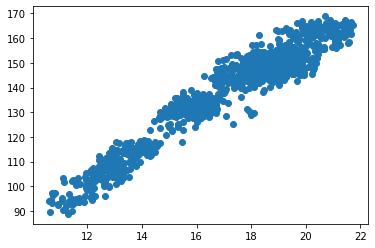

In [509]:
# now we can proceed with the analysis of the predictive power of the signal
# from the scatter plot, there seems to be some linear relationship between the two variables. 
finalCleanedData = cleanedData4.loc[:,orignalColumns]
plt.scatter(finalCleanedData['Signal'], finalCleanedData['Adj Close'])

In [510]:
# Define some functions needed for regression analysis

import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def trainTestSplit(data, trainPercentage=0.8):
    n = data.shape[0]
    trainLength = int(n*trainPercentage)
    return data.iloc[:trainLength, :], data.iloc[trainLength:, :]

def constructXandYFromDF(df, xCol, yCol):
    if len(xCol)==1:
        X = np.array(df[xCol]).reshape(-1,1)
    else:
        X = np.array(df[xCol])
    y = np.array(df[yCol])
    return X, y

def runLinearRegressionSKL(df, xCol, yCol):
    X, y = constructXandYFromDF(df, xCol, yCol)
    linReg = LinearRegression()
    linReg.fit(X, y)
    return linReg, linReg.score(X,y)

def runLinearRegressionSM(df, xCol, yCol):
    X, y = constructXandYFromDF(df, xCol, yCol)
    X2 = sm.add_constant(X)
    model = sm.OLS(y, X2)
    modelFitted = model.fit()
    return modelFitted

def MSEAndR2InTest(model, testData, xCol, yCol, DEBUG=False):
    X, y = constructXandYFromDF(testData, xCol, yCol)
    yPred = model.predict(X)
    if DEBUG:
        print(np.concatenate((y, yPred), axis=1))
    mse = mean_squared_error(y, yPred)
    r2 = r2_score(y, yPred)
    return mse, r2
    

In [511]:
trainData, testData = trainTestSplit(finalCleanedData, 0.8)
xCol = ['Signal']
yCol = ['Adj Close']
fittedModel = runLinearRegressionSM(trainData, ['Signal'], ['Adj Close'])

In [512]:
# from the model summary, we can see it is statistically significant with R2 around 0.93.
print(fittedModel.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 1.118e+04
Date:                Wed, 30 Jun 2021   Prob (F-statistic):               0.00
Time:                        23:58:59   Log-Likelihood:                -2525.2
No. Observations:                 825   AIC:                             5054.
Df Residuals:                     823   BIC:                             5064.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.3179      1.077     18.872      0.0

In [513]:
# get some performance measures of the model for in sample (IS) and out of sample (OOS) periods
fittedModelSKL, r2Score = runLinearRegressionSKL(trainData, xCol, yCol)
print('R2 score in sample: %.4f'% r2Score)
mse, r2 = MSEAndR2InTest(fittedModelSKL, testData, xCol, yCol, False)
print('Mean squared error: %.4f'% mse)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.4f'% r2)
# The negative R2 in the test or OOS period shows that with current split of train & test data. The model
# does not have any predictive power in the OOS period. Could it be due to that we used more distant data in the training period?
# In the next section I will test out various trailing periods used to predict 5 day OOS results. 

R2 score in sample: 0.9315
Mean squared error: 25.1576
Coefficient of determination: -0.1289


In [514]:
# Run a series of trailing periods for training model: from 30 to 210 days. 
# I didn't use rolling method, rather trunked all the data into segments needed for this analysis. 
def testBestTrainingPeriod(trainData, xCol, yCol):
    trailingPeriods = [30, 60, 90, 120, 150, 180, 210]
    predictPeriod = 5
    length = len(trainData)
    r2ArrayInSample = [None]*len(trailingPeriods)
    r2Array = [None]*len(trailingPeriods)
    for i,tp in enumerate(trailingPeriods):
        segLength = (tp+predictPeriod)
        segments = length//segLength
        r2InSample = []
        r2Temp = []
        for sgIndex in range(segments):
            segData = trainData[sgIndex*segLength:(sgIndex+1)*segLength]
            segTrain = segData[:tp]
            segTest = segData[tp:]
            fittedModelSKL, r2Score = runLinearRegressionSKL(segTrain, xCol, yCol)
            mse, r2 = MSEAndR2InTest(fittedModelSKL, segTest, xCol, yCol, False)
            r2InSample.append(r2Score)
            r2Temp.append(r2)
        r2ArrayInSample[i] = np.mean(r2InSample)    
        r2Array[i] = np.mean(r2Temp)
    return r2ArrayInSample, r2Array

In [515]:
r2IS, r2OOS = testBestTrainingPeriod(trainData, xCol, yCol)
print(r2IS)
print(r2OOS)
# The results show that the poor performance in the OOS period is not due to not using the most recent data for regression. 
# For training data from recent 30 to 210 days, none of them have good predictive power in the OOS periods. 

[0.14301474377520537, 0.2858786874909749, 0.37869945113357467, 0.35526547160280275, 0.4469698165043724, 0.6569324674954338, 0.6985398156673132]
[-57.69017826028357, -54.77546400843561, -210.6349182950279, -12.405065639226857, -35.75637864130962, -63.613724726661054, -27.32735374412249]


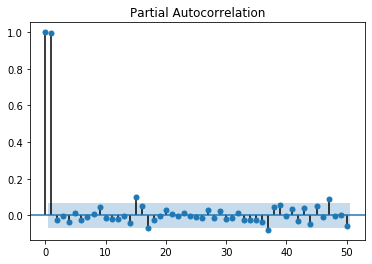

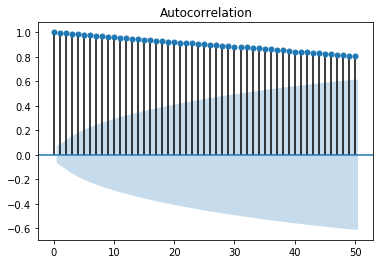

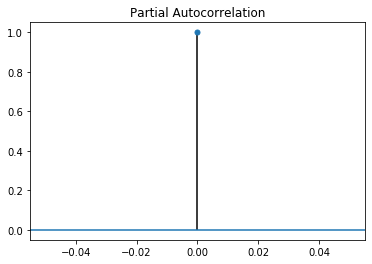

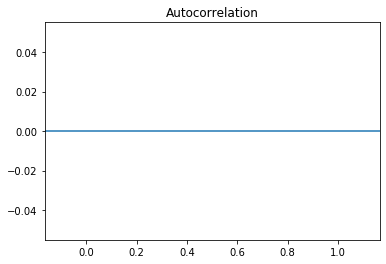

In [516]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plotAcfAndPacf(ts, lags=50):
    plot_pacf(ts, lags=50)
    plot_acf(ts, lags=50)

plotAcfAndPacf(trainData['Adj Close'], lags=50)

ret = cleanedData2.pct_change()
plotAcfAndPacf(ret['Adj Close'], lags=50)

# from the acf and pacf plots, we can see that the trainData (e.g., IS cleaned data) shows strong AR(1) process characteristics
# the percentage returns show there is no lag there, which is expected as the return operation removes trend. 

In [517]:
# let's prove that the ETF price is a strong AR(1) process by running linear regression w.r.t. the lag(1) term.
dataWithLag1 = finalCleanedData.copy()
newXCol = [yCol[i]+' Lag1' for i in range(len(yCol))]
dataWithLag1[newXCol] = finalCleanedData.shift()[yCol]
dataWithLag1.dropna(inplace=True)
dataWithLag1Train, dataWithLag1Test = trainTestSplit(dataWithLag1, 0.8)
dataWithLag1Train.head()

,Signal,Open,High,Low,Close,Adj Close,Adj Close Lag1
Date,,,,,,,
2015-11-20,13.608819,116.480003,117.360001,116.379997,116.809998,108.981323,108.281601
2015-11-23,12.990589,116.709999,117.889999,116.680000,117.389999,109.522453,108.981323
2015-11-24,12.667435,116.879997,118.419998,116.559998,118.250000,110.324837,109.522453
2015-11-25,13.019910,118.300003,119.320000,118.110001,119.169998,111.183159,110.324837
2015-11-27,12.879819,119.269997,119.900002,118.879997,119.620003,111.602997,111.183159


In [518]:
fittedAR1Model = runLinearRegressionSM(dataWithLag1Train, newXCol, yCol)
print(fittedAR1Model.summary())
# we can see that lag1 term is significant and the R2 is almost 1. Let's move ahead to see whether it has any predictive power. 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.812e+05
Date:                Wed, 30 Jun 2021   Prob (F-statistic):               0.00
Time:                        23:59:00   Log-Likelihood:                -1401.3
No. Observations:                 824   AIC:                             2807.
Df Residuals:                     822   BIC:                             2816.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3893      0.314      1.240      0.2

In [519]:
fittedAR1ModelSKL, r2AR1Score = runLinearRegressionSKL(dataWithLag1Train, newXCol, yCol)
print('R2 score in sample: %.4f'% r2AR1Score)
mse, r2 = MSEAndR2InTest(fittedAR1ModelSKL, dataWithLag1Test, newXCol, yCol, False)
print('Mean squared error out of sample: %.4f'% mse)
print('Coefficient of determination out of sample: %.4f'% r2)

R2 score in sample: 0.9955
Mean squared error out of sample: 2.3047
Coefficient of determination out of sample: 0.8966


In [520]:
# the R2 score shows that the AR(1) model has some 'predictive power' for the stock price, however, is it useful for trading?
# basically, we are interested in returns, i.e., how much change we expect the price to have in the future such that we can 
# trade (buy or sell) profitably. What the AR(1) model tells us is that tomorrow's price is most likely be oscillating around
# today's price, therefore, even if we just put today's price we will still end up with a good R2 score. However, this is of
# little practical use for trading. On the other hand, this result shows that the previous model based on 'signal' is much
# worse, which was beaten both in sample and out of sample. Based on all the results so far, we can say that the 'signal' does
# not have any 'extra' predictive power. Let's proceed working with the returns to see how it goes..

In [521]:
ret = finalCleanedData.pct_change()
ret.dropna(inplace=True)
retTrain, retTest = trainTestSplit(ret, 0.8)
retFittedModelSignal = runLinearRegressionSM(retTrain, xCol, yCol)
print(retFittedModelSignal.summary())
# The stats (e.g., p-value>0.05) show that the 'signal' cannot predict the ETF change/returns. 
# with the in-sample result totally statistically insignificant, there is no point to look at the stats for the test period. 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1576
Date:                Wed, 30 Jun 2021   Prob (F-statistic):              0.691
Time:                        23:59:00   Log-Likelihood:                 2603.5
No. Observations:                 824   AIC:                            -5203.
Df Residuals:                     822   BIC:                            -5194.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.306      0.1

In [522]:
retWithLag1 = dataWithLag1.pct_change()
retWithLag1.dropna(inplace=True)
retWithLag1Train, retWithLag1Test = trainTestSplit(retWithLag1, 0.8)
retFittedModelAR1 = runLinearRegressionSM(retWithLag1, newXCol, yCol)
print(retFittedModelAR1.summary())
# similarly, the AR(1) model for the return time series is also statistically insignificant, i.e., no explaining power (hence cannot 
# be used to predict either).This result also conforms with our previous acf & pacf plots for the return time series.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                 0.0004122
Date:                Wed, 30 Jun 2021   Prob (F-statistic):              0.984
Time:                        23:59:00   Log-Likelihood:                 3257.0
No. Observations:                1030   AIC:                            -6510.
Df Residuals:                    1028   BIC:                            -6500.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.420      0.1

In [523]:
# Even though we didn't find any predictive power for the next day's stock returns, that may not be the end of the story as we
# may not just trade 1 day, our trading horizon might change and our trading frequency doesn't have to be every day either. 
# the new question is whether some 'signals' at some special circumstances may have some predictive power hence can be used as trading
# signal for long or short or other relevant purposes?
# First consider the special circumstances when the 'Signal' moves more drastically. We can achieve this with the help of clustering. 
from sklearn.cluster import KMeans
import collections
kmeans = KMeans(n_clusters=10, random_state=0).fit(np.array(retTrain['Signal']).reshape(-1,1))
# print(kmeans.labels_)
print(kmeans.cluster_centers_)
print(collections.Counter(kmeans.labels_))
# From the cluster center values below, we can see that the no. 8 cluster has the lowest return. Anyways, I will run regression for each
# of those clusters to see whether any of them can have some predictive power. 

[[-0.01319642]
 [ 0.04995454]
 [-0.07167997]
 [ 0.02549375]
 [-0.03194509]
 [ 0.07236893]
 [ 0.00348141]
 [ 0.09555327]
 [-0.05267581]
 [-0.09577444]]
Counter({6: 143, 0: 116, 3: 113, 4: 106, 1: 97, 8: 72, 5: 62, 2: 59, 7: 36, 9: 20})


In [524]:
def singleClusterRegression(retTrain, kmeans, label, xCol, yCol, regressionLib = 'SM'):
    clusterDates = retTrain.index[kmeans.labels_==label]
    clusterData = retTrain.loc[clusterDates, :]
    if regressionLib == 'SM':
        clusterFittedModel = runLinearRegressionSM(clusterData, xCol, yCol)
        return clusterFittedModel, None
    elif regressionLib == 'SKL':
        clusterFittedModel, r2Score = runLinearRegressionSKL(clusterData, xCol, yCol)
        return clusterFittedModel, r2Score
    
def runRegressionForEachCluster(retTrain, kmeans, xCol, yCol):
    uniqueLabels = set(kmeans.labels_)
    clusterR2Scores = [None]*len(uniqueLabels)
    for label in uniqueLabels:
        fittedModelCluster, r2ScoreCluster = singleClusterRegression(retTrain, kmeans, label, xCol, yCol, 'SKL')
        clusterR2Scores[label] = r2ScoreCluster
    return clusterR2Scores
# Run regression for each cluster data points and output the R2. The no. 7 cluster with 0.2 R2 stands out.
clusterR2Scores = runRegressionForEachCluster(retTrain, kmeans, xCol, yCol)
clusterR2Scores

[0.0006706092431680856,
 0.0011406317477995476,
 0.04003495995492712,
 0.001948297180982439,
 0.012384097099497615,
 0.015569634046782575,
 0.0005100593796891761,
 0.05761705684941332,
 0.012797284705779122,
 0.20125100067388113]

In [525]:
# From the above R2 scores, it seems cluster 9 has the best explaining power. Perform some detailed analysis here. 
# First take a look at the IS regression results: it is encouraging to see that it is statistically significant. 
clusterFitted,_ = singleClusterRegression(retTrain, kmeans, 9, xCol, yCol, regressionLib = 'SM')
print(clusterFitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     4.535
Date:                Wed, 30 Jun 2021   Prob (F-statistic):             0.0473
Time:                        23:59:00   Log-Likelihood:                 57.567
No. Observations:                  20   AIC:                            -111.1
Df Residuals:                      18   BIC:                            -109.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0816      0.040      2.040      0.0

In [526]:
# Perform in sample and out of sample MSE and R2 computation for given cluster with clusterIndex. 
def getClusterMSEAndR2(trainData, testData, kmeans, clusterIndex, xCol, yCol, outOfSampleFlag='True', DEBUG=False):
    clusterFittedSKL,_ = singleClusterRegression(trainData, kmeans, clusterIndex, xCol, yCol, regressionLib = 'SKL')

    clusterDates = trainData.index[kmeans.labels_==clusterIndex]
    clusterTrainData = trainData.loc[clusterDates, :]
    
    clusterMaxRet = np.max(trainData.loc[trainData.index[kmeans.labels_==clusterIndex],['Signal']]).squeeze()
    clusterMinRet = np.min(trainData.loc[trainData.index[kmeans.labels_==clusterIndex],['Signal']]).squeeze()
    retTestSpecialCluster = retTest.loc[retTest['Signal']<=clusterMaxRet,:]
    retTestSpecialCluster = retTestSpecialCluster.loc[retTest['Signal']>=clusterMinRet,:]
    
    if outOfSampleFlag:
        mseCluster, r2Cluster = MSEAndR2InTest(clusterFittedSKL, retTestSpecialCluster, xCol, yCol, DEBUG)
        print('Root mean squared error out of sample: %.4f'% np.sqrt(mseCluster))
        print('Coefficient of determination out of sample: %.4f'% r2Cluster)
    else:
        mseCluster, r2Cluster = MSEAndR2InTest(clusterFittedSKL, clusterTrainData, xCol, yCol, DEBUG)
        print('Root mean squared error in sample: %.4f'% np.sqrt(mseCluster))
        print('Coefficient of determination in sample: %.4f'% r2Cluster)
        

In [527]:
print('In sample results:')
getClusterMSEAndR2(retTrain, retTest, kmeans, 9, xCol, yCol, False, False)
print('Out of sample results:')
getClusterMSEAndR2(retTrain, retTest, kmeans, 9, xCol, yCol, True, False)
# The out of sample (OOS) testing period doesn't seem to have equally good results as IS. Maybe we can improve the IS fitting a bit to
# get a better OOS results?

In sample results:
Root mean squared error in sample: 0.0136
Coefficient of determination in sample: 0.2013
Out of sample results:
Root mean squared error out of sample: 0.0171
Coefficient of determination out of sample: -0.1983


In [528]:
# Try a different type of regressor, say decision tree. 
from sklearn.tree import DecisionTreeRegressor

clusterIndex = 9
treeReg = DecisionTreeRegressor(min_samples_leaf=5)
clusterDates = retTrain.index[kmeans.labels_==clusterIndex]
clusterTrainData = retTrain.loc[clusterDates, :]
print(clusterTrainData.shape)

treeReg.fit(np.array(clusterTrainData[xCol]).reshape(-1,1), np.array(clusterTrainData[yCol]))

clusterMaxRet = np.max(retTrain.loc[retTrain.index[kmeans.labels_==clusterIndex],['Signal']]).squeeze()
clusterMinRet = np.min(retTrain.loc[retTrain.index[kmeans.labels_==clusterIndex],['Signal']]).squeeze()
print('Cluster Max and Min returns: {}, {}. '.format(clusterMaxRet, clusterMinRet))

retTestSpecialCluster = retTest.loc[retTest['Signal']<=clusterMaxRet,:]
retTestSpecialCluster = retTestSpecialCluster.loc[retTest['Signal']>=clusterMinRet,:]
print(retTestSpecialCluster.shape)

mseISTree, R2ISTree = MSEAndR2InTest(treeReg, clusterTrainData, xCol, yCol)
mseOOSTree, R2OOSTree = MSEAndR2InTest(treeReg, retTestSpecialCluster, xCol, yCol)

print('RMSE and R2 for both IS and OOS:')
print(np.sqrt(mseISTree), R2ISTree)
print(np.sqrt(mseOOSTree), R2OOSTree)

# the result seems promising with possitive R2 both IS and OOS. However, since there is only 2 data points in the OOS period, it is of
# no statistical significance here. We need to include more data points to test this idea. 


(20, 6)
Cluster Max and Min returns: -0.08638703110369861, -0.11082098075067948. 
(2, 6)
RMSE and R2 for both IS and OOS:
0.011820824402059081 0.39702304503329877
0.013879747245477931 0.20790388676180838


In [529]:
# Clustering gives some insight that when the singal moves down big, there can be some predictive power there. 
# And we can use various ways to pick up those regimes. Clustering is one way. Another way is to simply use z-score. 
zscoreTrain = zscore(retTrain[xCol])
retTrainMean = np.mean(retTrain[xCol]).squeeze()
retTrainStd = np.std(retTrain[xCol]).squeeze()

# let's say pick up zscore<-1.6 as the 'big-down' regime.
# This threshold is ajustable: I want to include more data points in the IS and OOS period without losing the characteristics of 
# 'big-down' uncovered by the above clustering algorithm. 
# -1.6 offers a good trade-off here: it translates to return less than -7%, which is not far from the threshold found by clustering.
zscoreThreshold = -1.6
print(retTrainMean + zscoreThreshold*retTrainStd)
retTrainBigDown = retTrain.loc[(zscoreTrain<zscoreThreshold).squeeze(),:]
print(retTrainBigDown.shape)

# There is an ajustable hyper-parameter for the decision tree regressor: min number of samples per leaf node. 
# It is a trade off: low number will get better in-sample performance however may be at risk of overfitting. 
# I tried several numbers from 1-10, it seems 4 gives fairly balanced results for both IS and OOS periods. 
treeRegBigDown = DecisionTreeRegressor(min_samples_leaf=4)
treeRegBigDown.fit(np.array(retTrainBigDown[xCol]).reshape(-1,1), np.array(retTrainBigDown[yCol]))

zscoreTest = zscore(retTest[xCol], retTrainMean, retTrainStd)
retTestBigDown = retTest.loc[(zscoreTest<zscoreThreshold).squeeze(),:]
print(retTestBigDown.shape)

mseISBigDownTree, R2ISBigDownTree = MSEAndR2InTest(treeRegBigDown, retTrainBigDown, xCol, yCol)
mseOOSBigDownTree, R2OOSBigDownTree = MSEAndR2InTest(treeRegBigDown, retTestBigDown, xCol, yCol)

print(np.sqrt(mseISBigDownTree), R2ISBigDownTree)
print(np.sqrt(mseOOSBigDownTree), R2OOSBigDownTree)

print(treeRegBigDown.predict(np.array(retTestBigDown[xCol]).reshape(-1,1)))
print(np.array(retTestBigDown[yCol]).squeeze())

-0.0734205090517953
(46, 6)
(4, 6)
0.009294961432675965 0.418544122441989
0.009876446511480933 0.41286076594567056
[-0.00492634  0.00577177  0.00044236 -0.00443852]
[-0.00828792  0.01910866 -0.01208186 -0.0110829 ]


In [530]:
# Try comparative AR(1) model in the 'big-down' case to see if it is significant in at least in-sample training period. 
# From the results, we can see that the AR(1) model for the 'big-down' period selected by signal does not have any explaining power. 
# This comparative study shows that the 'singal' may have some predictive power for this specific regime. 
zscoreTrainLag1 = zscore(retWithLag1Train[xCol])
retWithLag1BigDown = retWithLag1Train.loc[(zscoreTrainLag1<zscoreThreshold).squeeze(),:]
retWithLag1BigDownFittedModel = runLinearRegressionSM(retWithLag1BigDown, newXCol, yCol)
print(retWithLag1BigDownFittedModel.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                   0.06362
Date:                Wed, 30 Jun 2021   Prob (F-statistic):              0.802
Time:                        23:59:00   Log-Likelihood:                 137.49
No. Observations:                  46   AIC:                            -271.0
Df Residuals:                      44   BIC:                            -267.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.002     -0.270      0.7